In [1]:
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pickle
import glob
import cv2
import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as trainTestSplit

from skimage.feature import hog
from skimage import color, exposure


### Load The Data

In [2]:
dataFile = 'sample_data_file_names.p'

if not os.path.isfile(dataFile):
    path = "/home/carnd/vehicle_detection/data/"
    cars_udacity = glob.glob(path + 'Udacity/vehicles/*/*.jpeg')
    #print(len(cars_udacity))
    not_cars_udacity = glob.glob(path + 'Udacity/non-vehicles/*/*.jpeg')
    #print(len(not_cars_udacity))
    cars_gti = glob.glob(path + 'GTI/vehicles/*/*.png')
    #print(len(cars_gti))
    not_cars_gti = glob.glob(path + 'GTI/non-vehicles/*/*.png')
    #print(len(not_cars_gti))
    cars_kitti = glob.glob(path + 'KITTI/vehicles/*/*.png')
    #print(len(cars_kitti))
    not_cars_kitti = glob.glob(path + 'KITTI/non-vehicles/*/*.png')
    #print(len(not_cars_kitti))
    
    image_samples = cars_udacity + cars_gti + cars_kitti + not_cars_udacity + not_cars_gti + not_cars_kitti
    y = np.concatenate((np.ones(len(cars_udacity)),np.ones(len(cars_gti)),np.ones(len(cars_kitti)),
                       np.zeros(len(not_cars_udacity)),np.zeros(len(not_cars_gti)),np.zeros(len(not_cars_kitti))))

    imageSamplesFiles, y = shuffle(image_samples, y)
    X_train, X_test, y_train, y_test = trainTestSplit(imageSamplesFiles, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = trainTestSplit(X_train, y_train, test_size=0.2, random_state=42)

    data = {'X_train': X_train, 'X_test': X_test, 'X_valid': X_valid, 'y_train': y_train, 'y_test': y_test, 'y_valid': y_valid}
    pickle.dump(data, open(dataFile, 'wb'))

with open(dataFile, mode='rb') as f:
    data = pickle.load(f)
    X_train = data['X_train']
    X_test = data['X_test']
    X_valid = data['X_valid']
    y_train = data['y_train']
    y_test = data['y_test']
    y_valid = data['y_valid']

train_samples = [(X_train[i], y_train[i]) for i in range(len(X_train))] 
test_samples = [(X_test[i], y_test[i]) for i in range(len(X_test))] 
validation_samples = [(X_valid[i], y_valid[i]) for i in range(len(X_valid))] 


### Dataset Summary & Exploration


Number of training examples = 26566
Number of validation examples = 6642
Number of testing examples = 8304



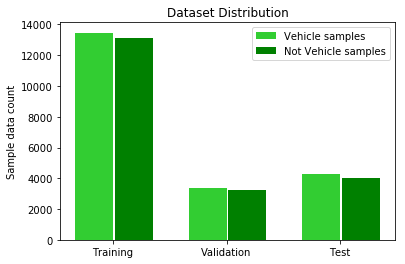

In [13]:

# Number of training examples
n_train = format(len(X_train))

# Number of validation examples
n_validation = format(len(X_valid))

# Number of testing examples
n_test = format(len(X_test))

# Shape of an traffic sign image
#image_shape = format(X_train[0].shape)

print()
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print()
#print("Image data shape =", image_shape)

train_car_samples= len([x for x in y_train if x == 1])
test_car_samples= len([x for x in y_test if x == 1])
valid_car_samples= len([x for x in y_valid if x == 1])


indices = range(0, 3)
width = np.min(np.diff(indices))/3
fig, ax = plt.subplots()
ax.bar(np.arange(3), (train_car_samples,valid_car_samples,test_car_samples), width, color='limegreen',label='Vehicle samples')
ax.bar(np.arange(3)+ 0.35, (int(n_train)-train_car_samples,int(n_validation)-valid_car_samples,int(n_test)-test_car_samples), width, color='green',label='Not Vehicle samples')
ax.set_ylabel('Sample data count')
ax.set_title('Dataset Distribution')
ax.set_xticks(np.arange(3) + width / 2)
ax.set_xticklabels(('Training', 'Validation', 'Test'))
ax.legend()
plt.show()

In [3]:
img_input_shape=(720, 1280, 3)
height_of_interest = (400, 700)
image_interest = (height_of_interest[1] - height_of_interest[0], img_input_shape[1], img_input_shape[2])
print("Region of interest for image frame:", image_interest)
print("Sample image shape:", (64, 64))

Region of interest for image frame: (300, 1280, 3)
Sample image shape: (64, 64)


## Model Architecture

My model consisted of the following layers:


| Layer | Component    	|     Output	 	|
|:----------------:|:------------:|:------------:|
| Lambda | Normalization and mean zero | (None, 300, 1280, 3) | 
| Convolution | filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu' | (None, 300, 1280, 16) | 
| Dropout	| rate=0.5 | (None, 300, 1280, 16)) | 
| Convolution |	filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'	|(None, 300, 1280, 32) | 
| Dropout	| rate=0.5 | (None, 300, 1280, 32) | 
| Convolution |filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'	| (None, 300, 1280, 64) | 
| Dropout	| rate=0.5 | (None, 300, 1280, 64) | 
| Max Pooling	| pool_size=(8, 8), padding='valid' | (None, 37, 160, 64) | 
| Dropout	| rate=0.5 | (None, 37, 160, 64) | 
| Convolution - Output	| filters=1, kernel_size=(8, 8), strides=(1, 1), padding='valid', activation='sigmoid' | (None, 30, 153, 1) | 

The network consists of a convolution neural network starting with normalization layer, followed by 3 convolution layers with kernel of 3x3 and 1 Max pool layer pool size of 8X8. filter sizes and depths between 16 and 64, followed by Dropout layers between them.

The model uses RELU activation on the layers to introduce nonlinearity, and the data is normalized in the model using a Keras lambda layer.

At the end of the model I have 1 convolution layer as the single output node for the prediction - Vehicle or not 

In [4]:
from keras.layers import Conv2D, Flatten, Lambda, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential

def generate_model(input_shape=(64, 64, 3)):
    dropout = 0.5
    model = Sequential()
    #normalization and mean zero - centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x / 255., input_shape=input_shape, output_shape=input_shape))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Dropout(dropout))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=1, kernel_size=(8, 8), activation="sigmoid"))
    return model

Using TensorFlow backend.


**Using Generator**

The dataset contains thousands of images (for vehicles and not-vehicles) and each image contains 12,288 pixels (64X64X3).
When the model is running on all of the dataset images we need a huge memory for the network training. 
I used Generator, enables to train the model by producing batches with data processing in real time, only when the model need it.

In [5]:
import cv2
import numpy as np
import random
from sklearn.utils import shuffle

def generator(samples, batch_size=32, is_training=False):
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images, classification = [], []
            X_train, y_train = [], []
            
            for batch_sample in batch_samples:
                fileName = batch_sample[0]
                image = cv2.imread(fileName)
                
                # Adding the original images, flipping them and append to the dataset
                images.append(image)
                classification.append(batch_sample[1])
                
                if (is_training):
                    images.append(cv2.flip(image, 1))
                    classification.append(batch_sample[1])
                 
            X_train = np.array(images)
            y_train = np.expand_dims(classification, axis=1)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
batch_size = 32
train_generator = generator(train_samples, batch_size, is_training=True)
validation_generator = generator(validation_samples, batch_size)
test_generator = generator(test_samples, batch_size)

In [9]:
from time import time
start_time = time()

epochs=5
batch_size = 32

model = generate_model()
model = Model(inputs=model.input, outputs=Flatten()(model.output))
#print(model.summary())
        
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_object = model.fit_generator(train_generator, steps_per_epoch= len(train_samples)*2/batch_size, 
                validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size,
                epochs=epochs, callbacks=[checkpoint])

total_time = time() - start_time
minutes, seconds = divmod(total_time, 60)
print ("Total time for training: ", minutes, "min, {:.0f}".format(seconds),  "s ")

Epoch 1/5
831/830 [==============================] - 709s - loss: 0.0671 - acc: 0.9080 - val_loss: 0.0497 - val_acc: 0.9660
Epoch 2/5
831/830 [==============================] - 709s - loss: 0.0199 - acc: 0.9753 - val_loss: 0.0223 - val_acc: 0.9834
Epoch 3/5
831/830 [==============================] - 710s - loss: 0.0159 - acc: 0.9804 - val_loss: 0.0219 - val_acc: 0.9786
Epoch 4/5
831/830 [==============================] - 710s - loss: 0.0128 - acc: 0.9843 - val_loss: 0.0164 - val_acc: 0.9864
Epoch 5/5
831/830 [==============================] - 710s - loss: 0.0123 - acc: 0.9857 - val_loss: 0.0154 - val_acc: 0.9855
Total time for training:  59.0 min, 11 s 


dict_keys(['val_loss', 'loss', 'acc', 'val_acc'])


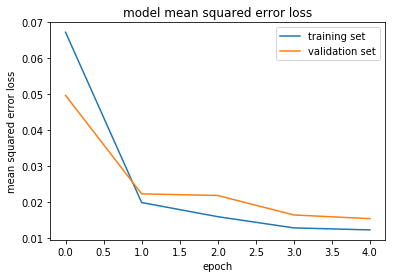

In [12]:
from keras.models import Model
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [14]:
accuracy = model.evaluate_generator(generator=test_generator, steps=len(test_samples)/ batch_size)
print('Test accuracy: ', accuracy)

Test accuracy:  [0.014720664625208617, 0.98819845845933596]


### Loading the model weights before using it to predict the search windows

In [16]:
model = generate_model(input_shape = image_interest)
model.load_weights('model.h5')

# save the architecture of the model as json
json_string = model.to_json()
print(json_string)
with open('model.json', 'w') as file:
    file.write(json_string)

{"config": [{"config": {"output_shape": [300, 1280, 3], "trainable": true, "name": "lambda_6", "output_shape_type": "raw", "arguments": {}, "dtype": "float32", "function_type": "lambda", "function": ["\u00e3\u0001\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0001\u0000\u0000\u0000\u0002\u0000\u0000\u0000S\u0000\u0000\u0000s\b\u0000\u0000\u0000|\u0000\u0000d\u0001\u0000\u001bS)\u0002N\u00e7\u0000\u0000\u0000\u0000\u0000\u00e0o@\u00a9\u0000)\u0001\u00da\u0001xr\u0002\u0000\u0000\u0000r\u0002\u0000\u0000\u0000\u00fa\u001e<ipython-input-4-f33f89634d27>\u00da\b<lambda>\t\u0000\u0000\u0000s\u0000\u0000\u0000\u0000", null, null], "batch_input_shape": [null, 300, 1280, 3]}, "class_name": "Lambda"}, {"config": {"kernel_regularizer": null, "trainable": true, "name": "conv2d_21", "filters": 16, "kernel_initializer": {"config": {"scale": 1.0, "seed": null, "distribution": "uniform", "mode": "fan_avg"}, "class_name": "VarianceScaling"}, "use_bias": true, "activity_regularizer": null, "activation": "r

In [32]:
model = generate_model(input_shape = image_interest)
model.load_weights('model.h5')

In [33]:
def search_windows(img):

    confidence_thresh = .5
    win_size = 64
    boxes = []
        
    # running on the region of interest only
    img_region = img[height_of_interest[0]:height_of_interest[1], :]
    img_region = np.expand_dims(img_region, axis=0)

    # 1. running model prediction on the region of interest
    # 2. convert the result to 2 dimentions (the model insist of 4 dimentions)
    # 3. using threshold of 0.5 on the results to get boolean classification results 
    model_detections = model.predict(img_region)
    model_detections = model_detections.reshape(model_detections.shape[1], model_detections.shape[2])
    model_detections = model_detections > confidence_thresh
    
    y_region = img_region.shape[1] / model_detections.shape[0]
    x_region = img_region.shape[2] / model_detections.shape[1]
    labels = label(model_detections, structure=[[1, 1, 1],[1, 1, 1],[1, 1, 1]])

    for box in range(labels[1]):

        nz = (labels[0] == box + 1).nonzero()
        nysteps = np.array(nz[0])
        nxsteps = np.array(nz[1])
        y_win_min = np.min(nysteps)
        x_win_min = np.min(nxsteps) - win_size/2
        x_win_max = np.max(nxsteps) + win_size/2
        y_win_max = np.max(nysteps) + win_size
        xspan = x_win_max - x_win_min
        yspan = y_win_max - y_win_min
        
        for x, y in zip(nxsteps, nysteps):

            offsetX = (x - x_win_min) / xspan * win_size
            offsetY = (y - y_win_min) / yspan * win_size
            top_left_X = int(round(x * x_region - offsetX, 0))
            top_left_Y = int(round(y * y_region - offsetY, 0))
            bottom_right_X = top_left_X + win_size
            bottom_right_Y = top_left_Y + win_size
            topLeft = (top_left_X, height_of_interest[0] + top_left_Y)
            bottomRight = (bottom_right_X, height_of_interest[0] + bottom_right_Y)

            boxes.append((topLeft, bottomRight))
            
    mask = np.zeros_like(img[:, :, 0]).astype(np.float)
    mask, heatMap = create_heatMap(mask, bBoxes=boxes)

    newBoxes = label(mask, structure=[[1, 1, 1],[1, 1, 1],[1, 1, 1]])
    save_boxes(newBoxes)

    return heatMap

In [40]:
def create_heatMap(mask, bBoxes):
    for box in bBoxes:
        mask[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        mask = np.clip(mask, 0, 255)
        
    heatMapInt = cv2.equalizeHist(mask.astype(np.uint8))
    heatMap = cv2.applyColorMap(heatMapInt, cv2.COLORMAP_HOT)
    heatMap = cv2.cvtColor(heatMap, code=cv2.COLOR_BGR2RGB)
    return mask, heatMap

# Adding the current boxes that were found, to the list of latest boxes
def save_boxes(newBoxes):
    global previous_boxes
    for i in range(newBoxes[1]):
        box = (newBoxes[0] == i + 1).nonzero()
        if (np.min(np.array(box[1])) > 300):
            previous_boxes.append([np.min(np.array(box[1])), np.min(np.array(box[0])), 
                                        np.max(np.array(box[1])), np.max(np.array(box[0]))])
            previous_boxes = previous_boxes[-45:] # will save the latest 45 boxes obly 

def group_regions():
    global previous_boxes
    #print(previous_boxes)
    #boxes, _ = cv2.groupRectangles(rectList=np.array(previous_boxes).tolist(), groupThreshold=0, eps=.0)
    boxes, _ = cv2.groupRectangles(rectList=np.array(previous_boxes).tolist(), groupThreshold=10, eps=.1)
    return boxes

def draw_boxes(img, bBoxes):
    for bBox in bBoxes:
        bBox = np.array(bBox)
        bBox = bBox.reshape(bBox.size)
        cv2.rectangle(img=img, pt1=(bBox[0], bBox[1]), pt2=(bBox[2], bBox[3]), color=(64,225,101), thickness=4)
        font=cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,'Vehicle',(bBox[0]+10, bBox[1]-5), font, 0.6,(255,255,255),2)


### Main pipeline
The methos below gets an image and perform the following steps:
1. crop the image for the region of interest (the road part of the image) - 300X1280
2. run the model prediction on the image to get the boxes
3. arrange the detected boxes from the model output
4. run HeatMap with threshold on the boxes array to detect the Hot pixels on the image
5. draw the boxes on the original image
The methos output is the original image with boxed around the detected cars on the image, including the HeatMap of the model output (for visualization)

In [41]:
def detect_vehicles(img, isTesting=False):

    # Search for matches by the model
    heatmap = search_windows(img)

    # group boxes togther to one 
    vBoxes = group_regions()
    
    # The boxes after prediction and heatMap threshold
    draw_boxes(img, vBoxes)
    
    if (isTesting): #Include the heatMap for display
        return img, heatmap
    return img

### Test Images
Running the Pipeline on the test images to get the final output with the detected boxes from the model, along with the heatMap of each image

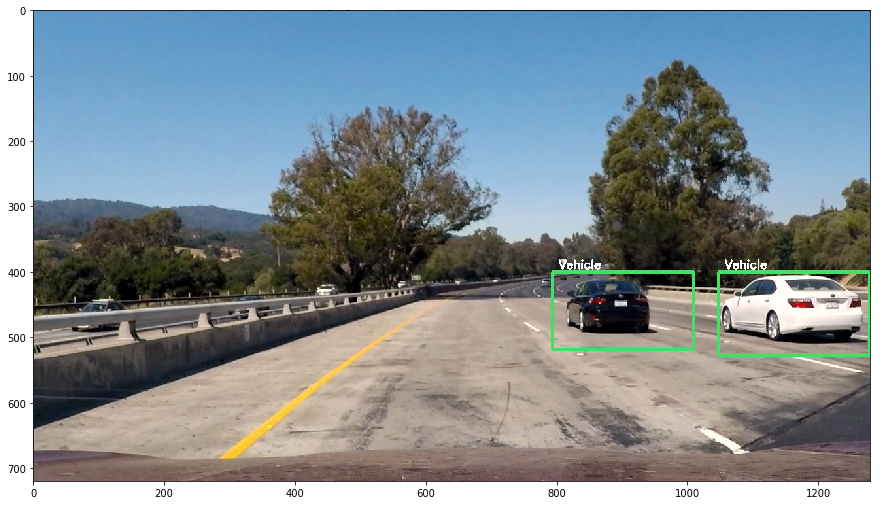

In [36]:
%matplotlib inline
previous_boxes=[]

path = '/home/carnd/vehicle_detection/'
img = mpimg.imread(path + 'test_images/test1.jpg')
output, heatmap = detect_vehicles(img)
plt.figure(figsize=(15, 12))
plt.imshow(output)

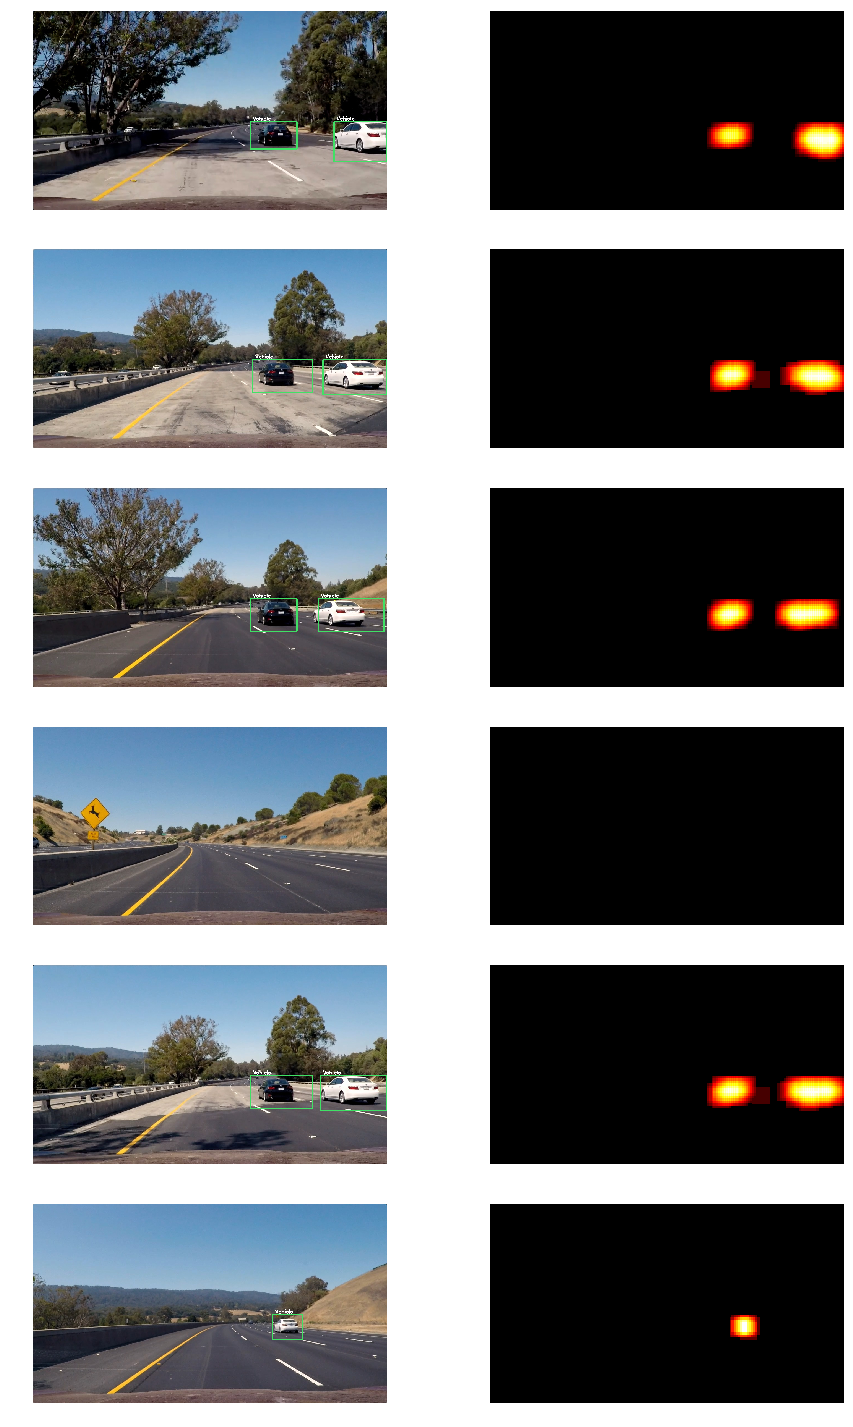

In [39]:
%matplotlib inline

sample_images = []
images = glob.glob(path + 'test_images/test*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    previous_boxes=[]
    output, heatmap = detect_vehicles(img)
    sample_images.append(output)
    sample_images.append(heatmap)
    
plt.figure(figsize=(15, 30))
for i in range(len(sample_images)):
    plt.subplot(7, 2, i+1)
    plt.imshow(sample_images[i]) 
    plt.axis('off')

### Test on Videos

In [42]:
# Test the pipeline for videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

previous_boxes=[]
path = '/home/carnd/vehicle_detection/test_video/'
white_output = (path + 'test_video_output.mp4')
clip1 = VideoFileClip(path + 'test_video.mp4')
white_clip = clip1.fl_image(detect_vehicles)#.subclip(6,10)
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video /home/carnd/vehicle_detection/test_video/test_video_output.mp4
[MoviePy] Writing video /home/carnd/vehicle_detection/test_video/test_video_output.mp4


 97%|█████████▋| 38/39 [00:21<00:00,  1.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/carnd/vehicle_detection/test_video/test_video_output.mp4 

CPU times: user 1min 34s, sys: 8.47 s, total: 1min 43s
Wall time: 22.9 s


In [44]:
# Main project_video output

previous_boxes=[]
path = '/home/carnd/vehicle_detection/test_video/'
white_output = (path + 'project_video_output.mp4')
clip1 = VideoFileClip(path + 'project_video.mp4')
white_clip = clip1.fl_image(detect_vehicles)#.subclip(1,8)
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video /home/carnd/vehicle_detection/test_video/project_video_output.mp4
[MoviePy] Writing video /home/carnd/vehicle_detection/test_video/project_video_output.mp4


100%|█████████▉| 1260/1261 [10:22<00:00,  1.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/carnd/vehicle_detection/test_video/project_video_output.mp4 

CPU times: user 50min 3s, sys: 4min 37s, total: 54min 41s
Wall time: 10min 23s
